# Ge271 Class Project
**Author:** Krittanon "Pond" Sirorattanakul <br>
**Date:** February 25, 2021

This is a Jupyter notebook for a final class project of Ge271 - Dynamics of Seismicity for Winter 2021 term.

## Objective
Declustering LFEs dataset from Nankai subduction zone.


## Data
JMA Unified Catalog (Hypocenters)

https://www.data.jma.go.jp/svd/eqev/data/bulletin/hypo_e.html

# Intial setup and data import

In [1]:
# Install necessary libraries
!apt-get install libgeos-dev
!pip install git+https://github.com/matplotlib/basemap
!pip install --upgrade GPy
!pip install obspy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
  Cloning https://github.com/matplotlib/basemap to /tmp/pip-req-build-htji71dk
  Running command git clone -q https://github.com/matplotlib/basemap /tmp/pip-req-build-htji71dk
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759564 sha256=6d2cfc1441d17e12deaf442b5722651d01239a369f7d66e9d87a8ed0ef47e415
  Stored in directory: /tmp/pip-ephem-wheel-cache-3fnhlyl6/wheels/1b/d0/56/82fb3be6540d550778368c43a72a88621f0b16961301fd7467
Successfully built basemap
Requirement already up-to-date: GPy in /usr/local/lib/python3.7/dist-packages (1.9.9)


In [2]:
# Link google colab with google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math

In [4]:
# Link the dateset
import sys
datapath = '/content/drive/My Drive/Ge271/data/'
sys.path.insert(1, datapath)

In [5]:
year_begin = 2000
year_end = 2018

In [6]:
import numpy as np

def check_int(s):
    new = s.strip()
    return new.isdigit()

time = []  # Japan Standard Time (UTC+9)
lat = []
lon = []
dep = []
mag = []
intensity = []

## Load LFEs data
for j in range(year_begin,year_end+1):
  f = open(datapath + 'h' + str(j))
  data = list(f)
  f.close()
  for i in range(len(data)):   # 1 = natural earthquake, 5 = LFEs 
    if data[i][60]=='5'  and check_int(data[i][52:54]) and  check_int(data[i][45:49]): 
      time.append(datetime(int(data[i][1:5]),int(data[i][5:7]),int(data[i][7:9]),
                      int(data[i][9:11]),int(data[i][11:13]),int(data[i][13:15]),int(int(data[i][15:17])*1e4)))
      lat.append(int(data[i][21:24]) + int(data[i][24:28])/(60*100))
      lon.append(int(data[i][32:36]) + int(data[i][36:40])/(60*100))
      dep.append(int(data[i][44:49])/100)
      mag.append(int(data[i][52:54])/10)
      intensity.append(data[i][61])

In [7]:
time = np.asarray(time)
lat = np.asarray(lat)
lon = np.asarray(lon)
dep = np.asarray(dep)
mag = np.asarray(mag)

# Useful functions

In [8]:
import pyproj

def polyconic(Lat, Diff_long, Lat_Orig):  #### we will also convert blh to xyz

#	Polyconic Projection
#	Input:
#		Lat 		= Latitude (decimal seconds)
#		Diff_long 	= Differential Longitude (decimal seconds)
#					relative to Central Meridian
#		Lat_Orig	= Latitude of Origin (decimal seconds)
#	Output: x =	Distance from Central Meridian
#		y = 	Distance from Origin to Latitude

     import math
     from math import sin as sin
     from math import cos as cos
     from math import sqrt as sqrt

     p1 = Lat_Orig; 
     p2 = Lat;
     il = Diff_long;

     arcone = 4.8481368e-6;
     esq = 6.7686580e-3;
     la = 6378206.4;
     a0 = 6367399.7;
     a2 = 32433.888;
     a4 = 34.4187;
     a6 = .0454;
     a8 = 6.0e-5;

     ip = p2 - p1;
     sinp2 = sin(p2 * arcone);
     cosp2 = cos(p2 * arcone);
     theta = il * sinp2;
     a = sqrt(1.0 - (esq * (2. * sinp2))) / (la * arcone);
     cot = cosp2 / sinp2;
     x = (cot * sin(theta * arcone)) / (a * arcone);
     ipr = ip * arcone;
     pr = ((p2 + p1) / 2.)*arcone;
     y = ((((a0*ipr) - ((a2*cos(2.*pr))*sin(ipr))) + ((a4*cos(4.*pr))*sin(2.*ipr))) - ((a6*cos(6.*pr))*sin(3.*ipr))) + ((a8*cos(8.*pr))*sin(4.*ipr));
     return x,y

    
def llh2localxy(lat, lon, lat_ori, lon_ori):
    # e.g.  lat = np.asarray([30, 32, 34])
    #       lon = np.asarray([100, 110, 120])
    #       lat_ori = 30
    #       lon_ori = 100
    #       llh2localxy(lat,lon,lat_ori,lon_ori)
    
    llh = np.vstack((np.asarray(lat),np.asarray(lon)))
    nsta = np.shape(llh)[1]
    
    lat = 3600.0 * llh[0]
    lon = 3600.0 * llh[1]

    Lat_Orig = 3600.0 * lat_ori
    Diff_long  = 3600.0 * lon_ori * np.ones(nsta) - lon
    
    x = np.zeros(nsta)
    y = np.zeros(nsta)
    for i in range(nsta):
        x[i], y[i] = polyconic(lat[i], Diff_long[i], Lat_Orig);

    # convert units from meter into kilometer and flip x-axis
    return x*-1/1000.0, y/1000.0

In [9]:
# Specify parameters
n = 50     # number of arrivals
rate = 0.2     # arrival rate
m = 10000   # number of simulations

def generate_poisson(n,rate,m):
  data = []
  for i in range(m):
    sim = []
    time = 0
    for j in range(n):
      interevent = np.random.exponential(1/rate)
      time = time + interevent
      sim.append(time)
    data.append(sim)
  data = np.array(data)
  return data

# Overview of the region of interest -- Nankai subduction zone

In [11]:
print("Number of regular earthquakes in this catalog:", len(time))

Number of regular earthquakes in this catalog: 51133


## Magnitude time series

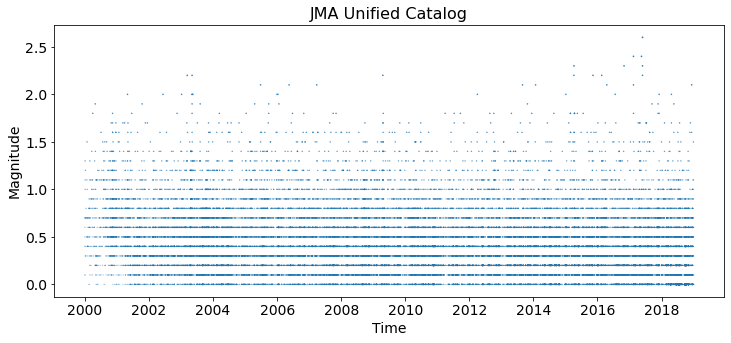

In [12]:
plt.figure(figsize=(12,5))
plt.scatter(time,mag,s=0.02*(3.5**np.asarray(mag)))
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Magnitude',fontsize=14)
plt.yticks(fontsize=14)
plt.title('JMA Unified Catalog',fontsize=16)
plt.show()

## Frequency-Magnitude distribution

The fact that magnitude is an increment of 0.1 can be an issue. We will need to use mc that is in between these increments (i.e. for M>0.6, we would need mc>=0.55; this is because changing mc between 0.51 - 0.60 will not change average M, but will change the b-values).

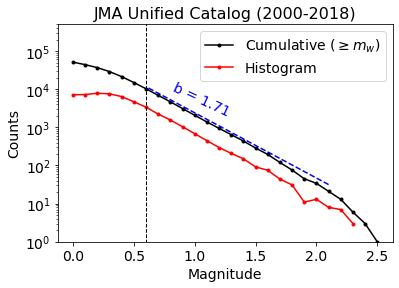

In [13]:
bin_size = 0.1
mc = 0.55

## Extract frequency and bin boundaries using np.histogram
a, b = np.histogram(mag, bins=np.arange(-0.05,3,bin_size))
bin_centers = np.ediff1d(b)/2 + b[:-1]

N = []
count = 0
for i in range(len(a)):
    count = count + a[len(a)-1-i]
    N = N + [count]
N_new = np.flip(np.asarray(N))
b = np.log10(np.exp(1))/(np.average(mag[mag>=mc])-mc)

plt.figure(figsize=(6,4))
plt.plot(bin_centers[0:-4],N_new[0:-4],c='black',marker='.',label=r'Cumulative ($\geq$$m_w$)')
plt.plot(bin_centers[0:-6],a[0:-6],c='red',marker='.',label='Histogram')
plt.plot([mc+0.05,mc+0.05],[0.1,500000],c='black',linestyle='--',linewidth=1)
plt.yscale('log')
plt.xlabel('Magnitude',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([1,500000])
plt.plot([2.1,0.6],[10**1.5,10**(1.5+1.5*b)],'b--')
plt.text(0.8,2e3,'b = ' + '%.2f' %(b),fontsize=14,rotation=-25,c='blue')
plt.legend(fontsize=14)
plt.title('JMA Unified Catalog (2000-2018)',fontsize=16)
plt.show()

## Spatial distribution of LFEs

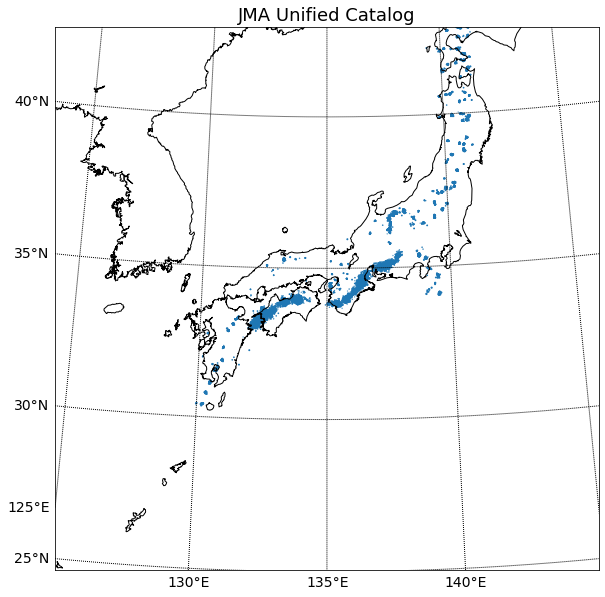

In [14]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10,10))
m = Basemap(width=2000000,height=2000000,projection='lcc',
            resolution='i',lat_0=34,lon_0=135)
m.drawcoastlines()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents(color='coral',lake_color='aqua')

m.scatter(lon, lat, latlon=True, s=mag)
parallels = np.arange(20.,50.,5.)
#  labels = [left, right, top or bottom]
m.drawparallels(parallels,labels=[True,False,True,False],fontsize=14)
meridians = np.arange(120.,150.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True],fontsize=14)
plt.title('JMA Unified Catalog',fontsize=18)
plt.show()

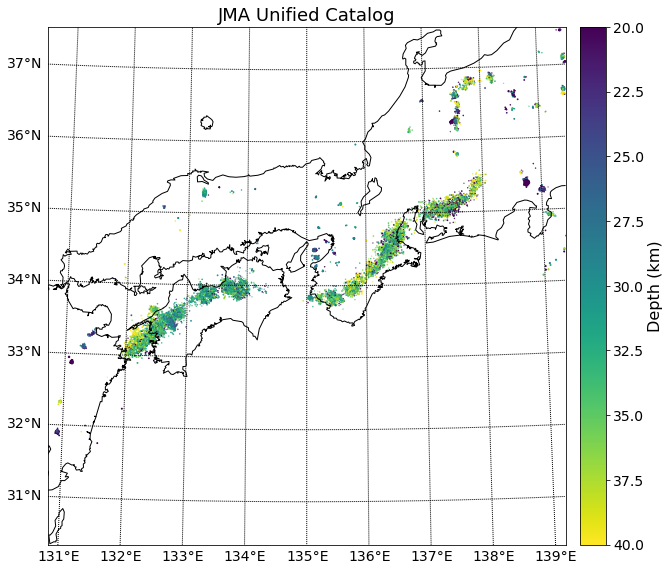

In [15]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10,10))
m = Basemap(width=800000,height=800000,projection='lcc',
            resolution='i',lat_0=34,lon_0=135)
m.drawcoastlines()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents(color='coral',lake_color='aqua')

m.scatter(lon, lat, latlon=True, c=dep, s=mag)
parallels = np.arange(20.,50.,1.)
#  labels = [left, right, top or bottom]
m.drawparallels(parallels,labels=[True,False,True,False],fontsize=14)
meridians = np.arange(130.,140.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],fontsize=14)
plt.title('JMA Unified Catalog',fontsize=18)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cb = plt.colorbar(cax=cax)
cb.set_label(label='Depth (km)',fontsize=16)
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, fontsize=14)
plt.clim(20, 40)
cb.ax.invert_yaxis()
plt.show()

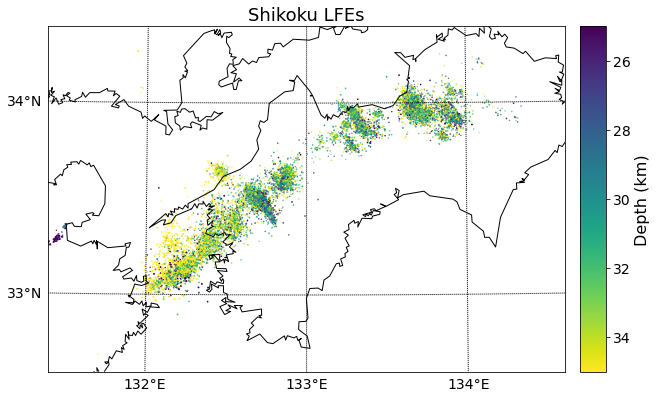

In [16]:
fig = plt.figure(figsize=(10,10))
m = Basemap(width=300000,height=200000,projection='lcc',
            resolution='i',lat_0=33.5,lon_0=133)
m.drawcoastlines()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents(color='coral',lake_color='aqua')

m.scatter(lon, lat, latlon=True, c=dep, s=mag)
parallels = np.arange(20.,50.,1.)
#  labels = [left, right, top or bottom]
m.drawparallels(parallels,labels=[True,False,True,False],fontsize=14)
meridians = np.arange(130.,140.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],fontsize=14)
plt.title('Shikoku LFEs',fontsize=18)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cb = plt.colorbar(cax=cax)
cb.set_label(label='Depth (km)',fontsize=16)
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, fontsize=14)
plt.clim(25,35)
cb.ax.invert_yaxis()
plt.show()

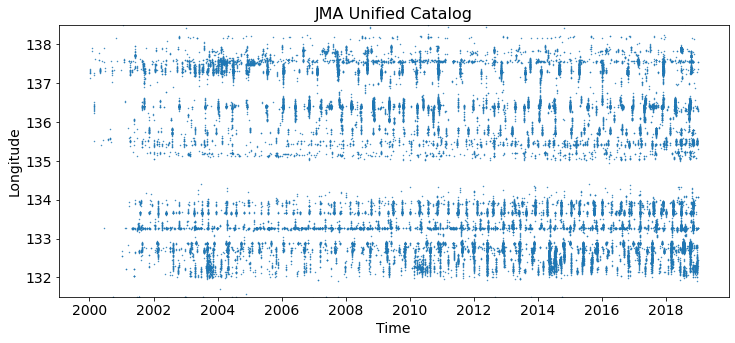

In [17]:
# Longitude-time plot
plt.figure(figsize=(12,5))
plt.scatter(time,lon,s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(datetime(2015, 5, 1),datetime(2015, 7, 1))
plt.ylim(131.5,138.5)
plt.title('JMA Unified Catalog',fontsize=16)
plt.show()

## Temporal distribution of LFEs

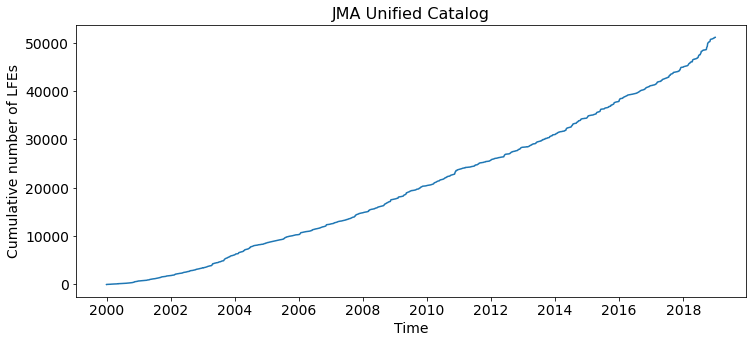

In [18]:
plt.figure(figsize=(12,5))
plt.plot(time,range(1,len(time)+1))
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Cumulative number of LFEs',fontsize=14)
plt.yticks(fontsize=14)
plt.title('JMA Unified Catalog',fontsize=16)
plt.show()

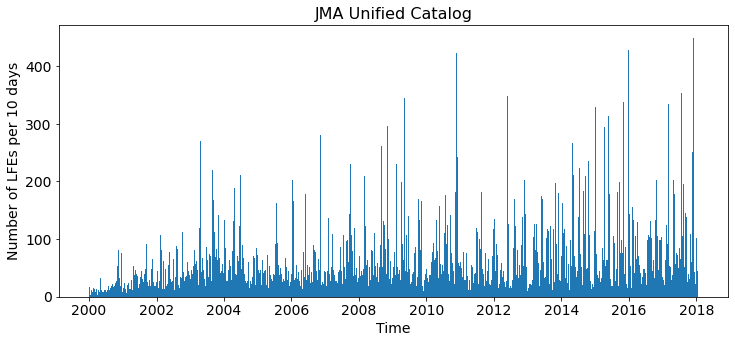

In [19]:
plt.figure(figsize=(12,5))
bins = [datetime(2000,1,1) + n*timedelta(10) for n in range(660)]
plt.hist(time,bins=bins)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Number of LFEs per 10 days',fontsize=14)
plt.yticks(fontsize=14)
plt.title('JMA Unified Catalog',fontsize=16)
plt.show()

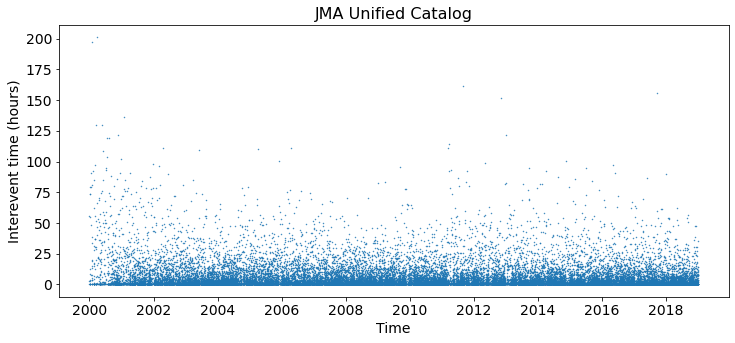

In [20]:
convert_dt = np.vectorize(lambda x: x.total_seconds())
interevent = convert_dt(np.diff(time))
interevent = interevent/3600

plt.figure(figsize=(12,5))
plt.scatter(time[0:-1],interevent,s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Interevent time (hours)',fontsize=14)
plt.yticks(fontsize=14)
plt.title('JMA Unified Catalog',fontsize=16)
plt.show()

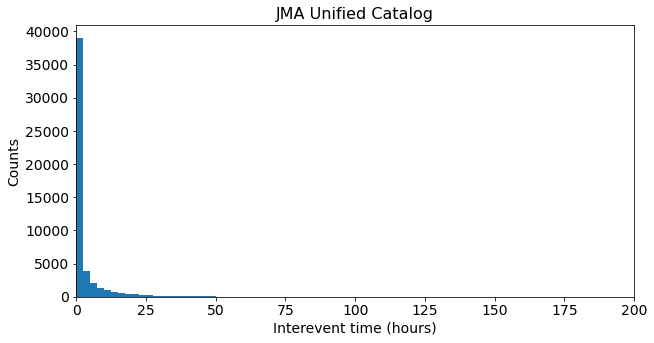

In [21]:
bins = [2.5*i for i in range(200)]

plt.figure(figsize=(10,5))
plt.hist(interevent,bins=bins)
plt.xlabel('Interevent time (hours)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.yticks(fontsize=14)
plt.title('JMA Unified Catalog',fontsize=16)
plt.xlim(0,200)
plt.show()

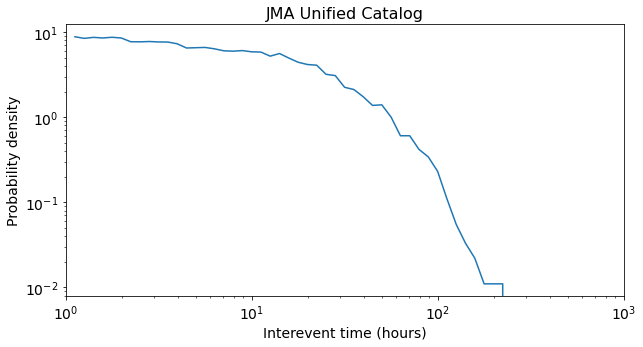

In [22]:
bins = [0.05*i for i in range(200)]

counts, bins = np.histogram(np.log10(interevent),bins=bins)
t = bins[0:-1] + 0.5*(bins[1]-bins[0])
plt.figure(figsize=(10,5))
plt.plot(10**(bins[0:-1]+(bins[1]-bins[0])),counts/(sum(counts)/len(bins))) # somehow scaling is wrong, check by using sum(counts)/len(bins)
plt.xlabel('Interevent time (hours)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Probability density',fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.yticks(fontsize=14)
plt.title('JMA Unified Catalog',fontsize=16)
plt.xlim([1,1e3])
plt.show()

# Shikoku

In [23]:
mask = (lat>=32.5) & (lat<=34.5) & (lon>=131.5) & (lon<=134.5) & (time>=datetime(2000,1,1))

In [24]:
shikoku_lat = lat[mask]
shikoku_lon = lon[mask]
shikoku_dep = dep[mask]
shikoku_mag = mag[mask]
shikoku_time = time[mask]

In [25]:
print("Number of regular earthquakes in this area:", len(shikoku_time))

Number of regular earthquakes in this area: 17993


## Frequency Magnitude Distribution

In [26]:
## Convert latitude, longitude to UTM 
ori_lat = 33.5
ori_lon = 132.5
shikoku_x, shikoku_y = llh2localxy(shikoku_lat, shikoku_lon, ori_lat, ori_lon)
shikoku_x = shikoku_x/1000   # convert to km
shikoku_y = shikoku_y/1000   # convert to km

In [27]:
## Convert time to year since 2010
convert_dt = np.vectorize(lambda x: x.total_seconds())
shikoku_years = convert_dt(shikoku_time - datetime(2000,1,1))/(3600*24*365.2422)

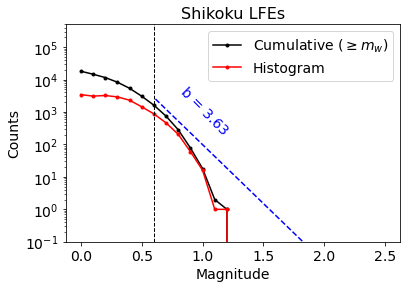

In [28]:
bin_size = 0.1
mc = 0.55

## Extract frequency and bin boundaries using np.histogram
a, b = np.histogram(shikoku_mag, bins=np.arange(-0.05,3,bin_size))
bin_centers = np.ediff1d(b)/2 + b[:-1]

N = []
count = 0
for i in range(len(a)):
    count = count + a[len(a)-1-i]
    N = N + [count]
N_new = np.flip(np.asarray(N))
b = np.log10(np.exp(1))/(np.average(shikoku_mag[shikoku_mag>=mc])-mc)

plt.figure(figsize=(6,4))
plt.plot(bin_centers[0:-4],N_new[0:-4],c='black',marker='.',label=r'Cumulative ($\geq$$m_w$)')
plt.plot(bin_centers[0:-6],a[0:-6],c='red',marker='.',label='Histogram')
plt.plot([mc+0.05,mc+0.05],[0.1,500000],c='black',linestyle='--',linewidth=1)
plt.yscale('log')
plt.xlabel('Magnitude',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.1,500000])
plt.plot([2.1,0.6],[10**-2,10**(-2+1.5*b)],'b--')
plt.text(0.8,2e2,'b = ' + '%.2f' %(b),fontsize=14,rotation=-45,c='blue')
plt.legend(fontsize=14)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

## Shikoku Spatio-temporal Distribution of LFEs

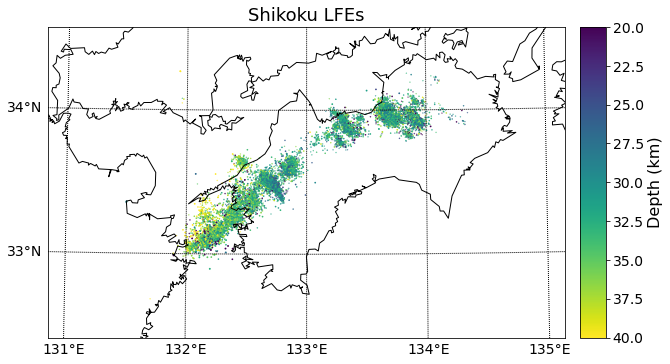

In [29]:
fig = plt.figure(figsize=(10,6))
m = Basemap(width=400000,height=240000,projection='lcc',
            resolution='i',lat_0=33.5,lon_0=133)
m.drawcoastlines()

m.scatter(shikoku_lon, shikoku_lat, latlon=True, c=shikoku_dep, s=shikoku_mag)
parallels = np.arange(20.,50.,1.)
#  labels = [left, right, top or bottom]
m.drawparallels(parallels,labels=[True,False,True,False],fontsize=14)
meridians = np.arange(130.,140.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],fontsize=14)
plt.title('Shikoku LFEs',fontsize=18)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cb = plt.colorbar(cax=cax)
cb.set_label(label='Depth (km)',fontsize=16)
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, fontsize=14)
plt.clim(20, 40)
cb.ax.invert_yaxis()
plt.show()

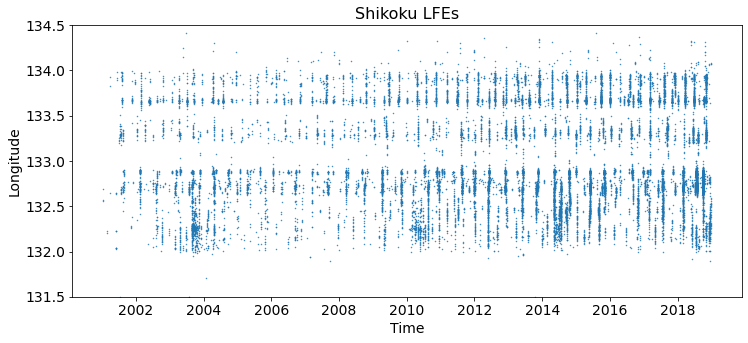

In [30]:
# Longitude-time plot
plt.figure(figsize=(12,5))
plt.scatter(shikoku_time,shikoku_lon,s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(datetime(2015, 5, 1),datetime(2015, 7, 1))
plt.ylim(131.5,134.5)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

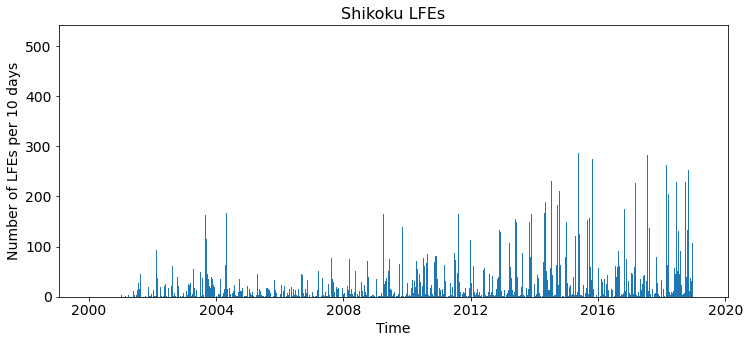

In [31]:
plt.figure(figsize=(12,5))
bins = [datetime(2000,1,1) + n*timedelta(10) for n in range(700)]
plt.hist(shikoku_time,bins=bins)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Number of LFEs per 10 days',fontsize=14)
plt.yticks(fontsize=14)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

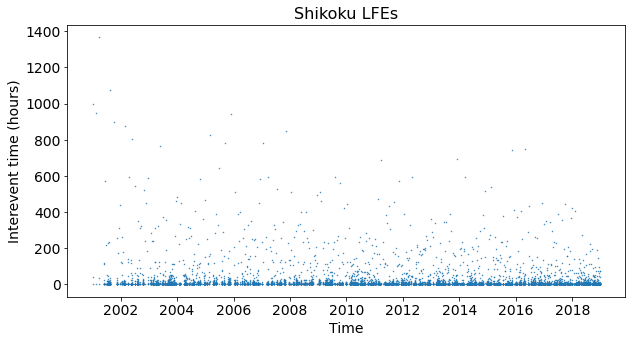

In [32]:
convert_dt = np.vectorize(lambda x: x.total_seconds())
shikoku_interevent = convert_dt(np.diff(shikoku_time))
shikoku_interevent = shikoku_interevent/(3600)

plt.figure(figsize=(10,5))
plt.scatter(shikoku_time[0:-1],shikoku_interevent,s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Interevent time (hours)',fontsize=14)
plt.yticks(fontsize=14)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

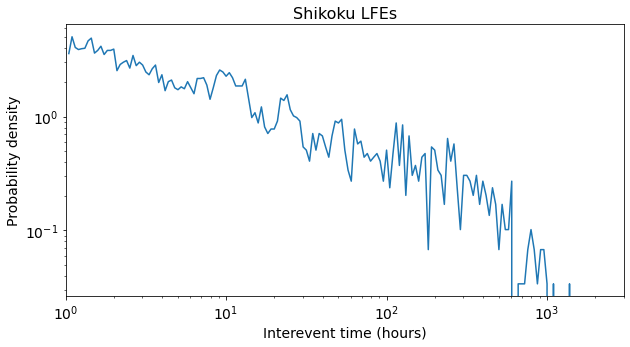

In [33]:
bins = [0.02*i for i in range(200)]

counts, bins = np.histogram(np.log10(shikoku_interevent),bins=bins)
t = bins[0:-1] + 0.5*(bins[1]-bins[0])
plt.figure(figsize=(10,5))
plt.plot(10**(bins[0:-1]+(bins[1]-bins[0])),counts/(sum(counts)/len(bins))) # somehow scaling is wrong, check by using sum(counts)/len(bins)
plt.xlabel('Interevent time (hours)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Probability density',fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.yticks(fontsize=14)
plt.title('Shikoku LFEs',fontsize=16)
plt.xlim([1,3e3])
plt.show()

## Declustering with Method by Zaliapin and Ben-zion (2013)

### Declustering

In [34]:
from obspy.geodetics.base import gps2dist_azimuth
import math

b = 1.71
D = 1.6
mc = 0.55

nnd = []
R = []
T = [] 
for k in range(len(shikoku_years)):
  if k%1000==0:
    print(k)
  tau_ij = []
  r_ij = []
  eta_ij = []
  mag_ij = []
  for i in range(len(shikoku_years)):
    if i!=k:
      dt = shikoku_years[k]-shikoku_years[i] #years
      if dt > 0:
        tau_ij.append(dt) 
      else:
        dt = math.inf
        tau_ij.append(dt)
      d = np.sqrt((shikoku_x[k]-shikoku_x[i])**2+(shikoku_y[k]-shikoku_y[i])**2)
      r_ij.append(d) # km
      eta_ij.append(dt*(d**D)*10**(-b*(shikoku_mag[i]-mc)))
      mag_ij.append(mag[i])
  eta_min = min(eta_ij)
  index = eta_ij.index(eta_min)
  nnd.append(eta_min)
  R.append(r_ij[index]*10**(-b*0.5*(mag_ij[index]-mc)))
  T.append(tau_ij[index]*10**(-b*0.5*(mag_ij[index]-mc)))

0
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


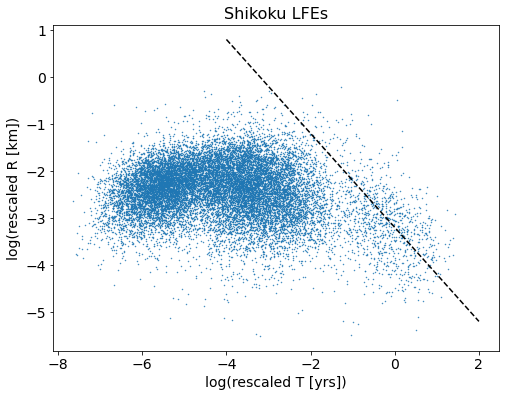

In [35]:
rescaled_T = np.log10(T)
rescaled_R = np.log10(R)
plt.figure(figsize=(8,6))
plt.scatter(rescaled_T,rescaled_R,s=0.2)
plt.plot([-4,2],[0.8,-5.2],'k--') # R = -T-3.2
plt.xlabel('log(rescaled T [yrs])',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log(rescaled R [km])',fontsize=14)
plt.yticks(fontsize=14)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

In [36]:
from scipy.stats import kde

mask = (np.isinf(rescaled_T)) | (np.isinf(rescaled_R))
nbins = 400
x = rescaled_T[~mask]
y = rescaled_R[~mask]
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

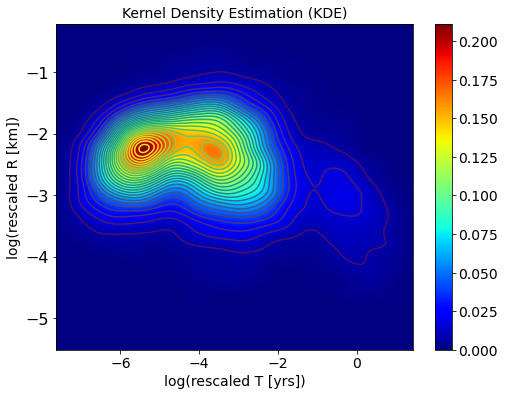

In [37]:
plt.figure(figsize=(8,6))
plt.pcolormesh(xi,yi,zi.reshape(xi.shape),cmap=plt.cm.jet)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.contour(xi,yi,zi.reshape(xi.shape),30)
plt.clim([0,0.2])
plt.xlabel('log(rescaled T [yrs])',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log(rescaled R [km])',fontsize=14)
plt.yticks(fontsize=16)
plt.title('Kernel Density Estimation (KDE)',fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


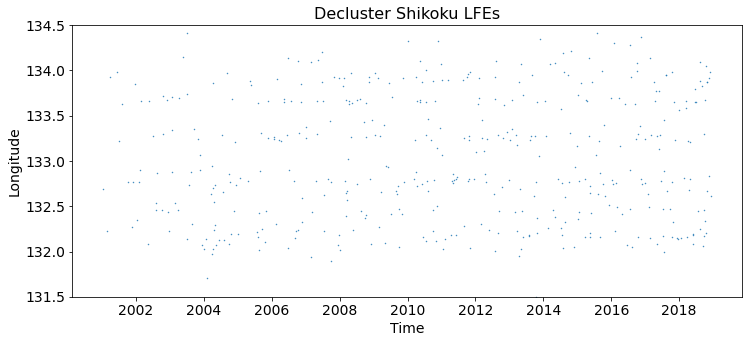

In [38]:
index = (np.log10(R)>-np.log10(T)-3.2)
shikoku_time_declust = shikoku_time[index]

plt.figure(figsize=(12,5))
plt.scatter(shikoku_time_declust,shikoku_lon[index],s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Decluster Shikoku LFEs',fontsize=16)
plt.show()

### Declustered -- Background rate

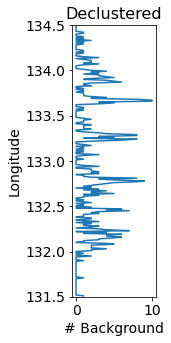

In [183]:
# Number of events vs longitude (before decluster)
bins = [131.5+0.01*i for i in range(300)]

counts, bins = np.histogram(shikoku_lon[index],bins=bins)
t = bins[0:-1] + 0.5*(bins[1]-bins[0])
plt.figure(figsize=(1.5,5))
plt.plot(counts,bins[0:-1]+(bins[1]-bins[0])) # somehow scaling is wrong, check by using sum(counts)/len(bins)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('# Background',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

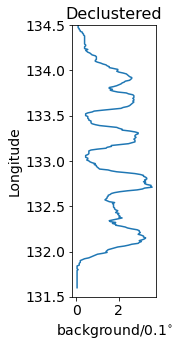

In [196]:
# Number of events vs longitude (before decluster, moving window)
bins = [131.5+0.01*i for i in range(300)]
background = []
decluster = shikoku_lon[index]

for i in range(len(bins)-1):
  mask = (decluster>=bins[i]) & (decluster<bins[i]+0.2)
  background.append(len(decluster[mask])/20)

t = np.asarray(bins[0:-1]) + 0.1
plt.figure(figsize=(1.5,5))
plt.plot(background,t) # somehow scaling is wrong, check by using sum(counts)/len(bins)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel(r'background/0.1$^{\circ}$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

In [197]:
# Number of events vs longitude (before decluster)
bins = [131.5+0.01*i for i in range(300)]
counts = []

for i in range(len(bins)-1):
  mask = (shikoku_lon>=bins[i]) & (shikoku_lon<bins[i]+0.2)
  counts.append(sum(mask))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


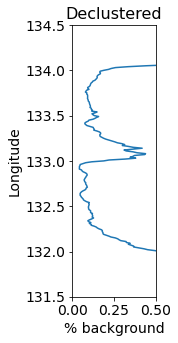

In [215]:
t = np.asarray(bins[0:-1]) + 0.1
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(background)*100/np.asarray(counts),t)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('% background',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,0.5])
plt.ylim(131.5,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


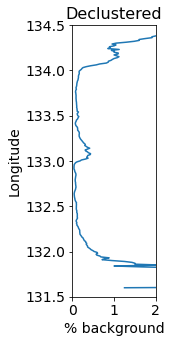

In [216]:
t = np.asarray(bins[0:-1]) + 0.1
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(background)*100/np.asarray(counts),t)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('% background',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,2])
plt.ylim(131.5,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

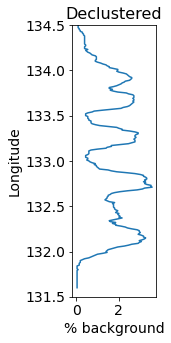

In [206]:
t = np.asarray(bins[0:-1]) + 0.1
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(background),t)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('% background',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim([0,0.01])
plt.ylim(131.5,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

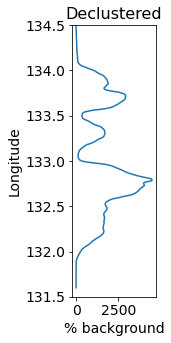

In [207]:
t = np.asarray(bins[0:-1]) + 0.1
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(counts),t)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('% background',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim([0,0.01])
plt.ylim(131.5,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

### Clustered -- Coefficient of Variations

In [41]:
# Coefficient of Variations
# Fraction of aftershocks vs longitude

bins = [131.5+0.01*i for i in range(300)]
fraction = []
cov_max = []
cov_min = []
convert_dt = np.vectorize(lambda x: x.total_seconds())

for i in range(len(bins)-1):
  mask = (shikoku_lon>bins[i]) & (shikoku_lon<bins[i]+0.2)
  if sum(mask)>3:
    bin_interevent = convert_dt(np.diff(shikoku_time[mask]))
    bin_interevent = bin_interevent/(3600)
    fraction.append(np.std(bin_interevent)/np.average(bin_interevent))
    rate = sum(mask)/(18*365*24)   #/hours
    data = generate_poisson(sum(mask),rate,39)
    cov = []
    for j in range(39):
      bin_interevent = np.diff(data[j])
      cov.append(np.std(bin_interevent)/np.average(bin_interevent))
    cov_max.append(max(cov))
    cov_min.append(min(cov))    
  else:
    fraction.append(math.inf)
    cov_max.append(math.inf)
    cov_min.append(math.inf)

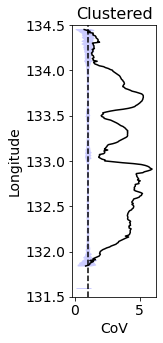

In [42]:
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(fraction),np.asarray(bins[0:-1])+0.1,'k')
plt.fill_betweenx(np.asarray(bins[0:-1])+0.1,np.asarray(cov_max),np.asarray(cov_min),color=[0.8,0.8,1])
plt.plot([1,1],[131.5,134.5],'k--')
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('CoV',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Clustered',fontsize=16)
plt.show()

### Declustered -- Coefficient of Variations

In [43]:
# Coefficient of Variations
# Fraction of aftershocks vs longitude

bins = [132+0.05*i for i in range(50)]
fraction = []

for i in range(len(bins)-1):
  mask = (shikoku_lon>bins[i]) & (shikoku_lon<bins[i+1])
  if sum(mask)>3:
    convert_dt = np.vectorize(lambda x: x.total_seconds())
    bin_interevent = convert_dt(np.diff(shikoku_time[mask]))
    bin_interevent = bin_interevent/(3600)
    fraction.append(np.std(bin_interevent)/np.average(bin_interevent))
  else:
    fraction.append(math.inf)

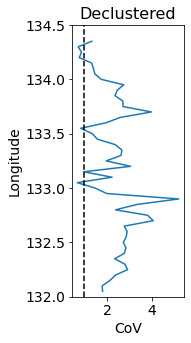

In [44]:
plt.figure(figsize=(2,5))
plt.plot(np.asarray(fraction),np.asarray(bins[0:-1])+(bins[1]-bins[0]))
plt.plot([1,1],[132,134.5],'k--')
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('CoV',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(132,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

In [45]:
# Coefficient of Variations
# Fraction of aftershocks vs longitude

bins = [131.5+0.01*i for i in range(300)]
fraction = []
cov_max = []
cov_min = []

decluster_lon = shikoku_lon[index]
decluster_time = shikoku_time[index]

for i in range(len(bins)-1):
  mask = (decluster_lon>bins[i]) & (decluster_lon<bins[i]+0.2)
  if sum(mask)>3:
    convert_dt = np.vectorize(lambda x: x.total_seconds())
    bin_interevent = convert_dt(np.diff(decluster_time[mask]))
    bin_interevent = bin_interevent/(3600)
    fraction.append(np.std(bin_interevent)/np.average(bin_interevent))
    rate = sum(mask)/(18*365*24)   #/hours
    data = generate_poisson(sum(mask),rate,39)
    cov = []
    for j in range(39):
      bin_interevent = np.diff(data[j])
      cov.append(np.std(bin_interevent)/np.average(bin_interevent))
    cov_max.append(max(cov))
    cov_min.append(min(cov))    
  else:
    fraction.append(math.inf)
    cov_max.append(math.inf)
    cov_min.append(math.inf)

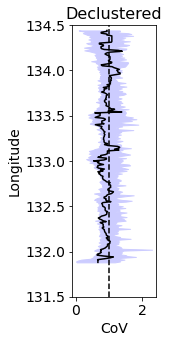

In [46]:
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(fraction),np.asarray(bins[0:-1])+0.1,'k')
plt.fill_betweenx(np.asarray(bins[0:-1])+0.1,np.asarray(cov_max),np.asarray(cov_min),color=[0.8,0.8,1])
plt.plot([1,1],[131.5,134.5],'k--')
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('CoV',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Declustered',fontsize=16)
plt.show()

### Understanding rescaled space-time

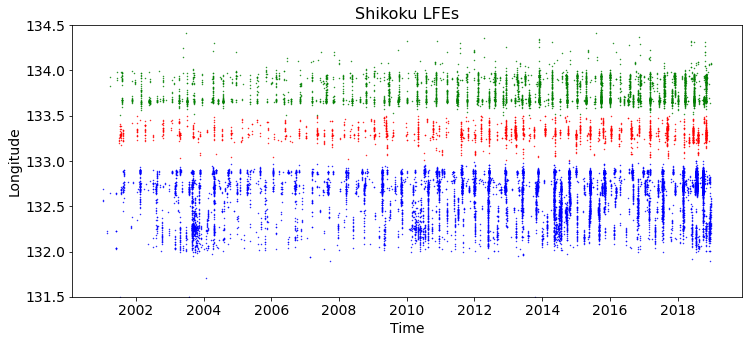

In [47]:
# Longitude-time plot
# Color coded by longitudes
plt.figure(figsize=(12,5))
mask = (shikoku_lon<=133)
plt.scatter(shikoku_time[mask],shikoku_lon[mask],s=0.2,c='b')
mask = (shikoku_lon>133) & (shikoku_lon<=133.5)
plt.scatter(shikoku_time[mask],shikoku_lon[mask],s=0.2,c='r')
mask = (shikoku_lon>133.5)
plt.scatter(shikoku_time[mask],shikoku_lon[mask],s=0.2,c='g')
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(datetime(2015, 5, 1),datetime(2015, 7, 1))
plt.ylim(131.5,134.5)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

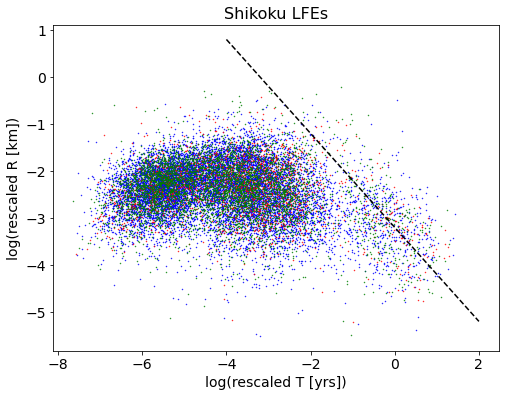

In [48]:
# Color coded by longitudes
plt.figure(figsize=(8,6))
mask = (shikoku_lon<=133)
plt.scatter(rescaled_T[mask],rescaled_R[mask],s=0.2,c='b')
mask = (shikoku_lon>133) & (shikoku_lon<=133.5)
plt.scatter(rescaled_T[mask],rescaled_R[mask],s=0.2,c='r')
mask = (shikoku_lon>133.5)
plt.scatter(rescaled_T[mask],rescaled_R[mask],s=0.2,c='g')
plt.plot([-4,2],[0.8,-5.2],'k--') # R = -T-3.2
plt.xlabel('log(rescaled T [yrs])',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log(rescaled R [km])',fontsize=14)
plt.yticks(fontsize=14)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


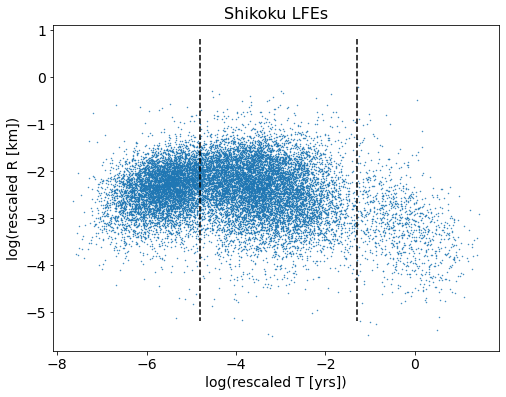

In [49]:
rescaled_T = np.log10(T)
rescaled_R = np.log10(R)
plt.figure(figsize=(8,6))
plt.scatter(rescaled_T,rescaled_R,s=0.2)
plt.plot([-4.8,-4.8],[0.8,-5.2],'k--') # T>-4.8
plt.plot([-1.3,-1.3],[0.8,-5.2],'k--') # T>-4.8
plt.xlabel('log(rescaled T [yrs])',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log(rescaled R [km])',fontsize=14)
plt.yticks(fontsize=14)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

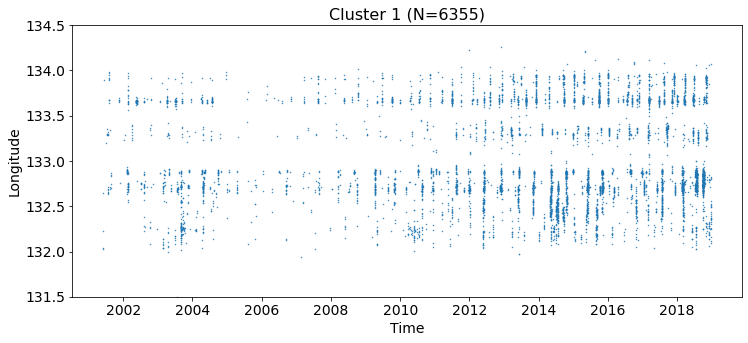

In [50]:
# Left-handed side
index = (np.log10(T)<-4.8)
shikoku_time_declust = shikoku_time[index]

plt.figure(figsize=(12,5))
plt.scatter(shikoku_time_declust,shikoku_lon[index],s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Cluster 1 (N=' + str(len(shikoku_time_declust)) + ')',fontsize=16)
plt.show()

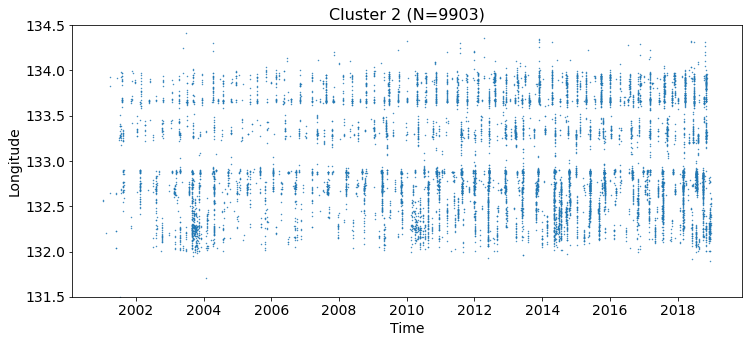

In [51]:
# middle panel
index = (np.log10(T)>-4.8) & (np.log10(T)<-1.3)
shikoku_time_declust = shikoku_time[index]

plt.figure(figsize=(12,5))
plt.scatter(shikoku_time_declust,shikoku_lon[index],s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Cluster 2 (N=' + str(len(shikoku_time_declust)) + ')',fontsize=16)
plt.show()

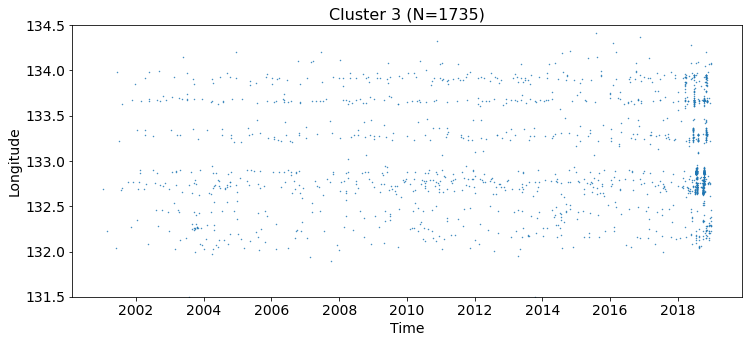

In [52]:
# Right-handed side
index = (np.log10(T)>-1.3)
shikoku_time_declust = shikoku_time[index]

plt.figure(figsize=(12,5))
plt.scatter(shikoku_time_declust,shikoku_lon[index],s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Cluster 3 (N=' + str(len(shikoku_time_declust)) + ')',fontsize=16)
plt.show()

## Determine the Background Rate from Gamma Distribution

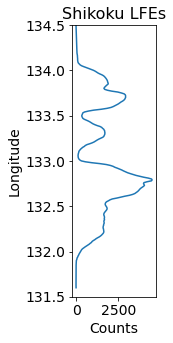

In [185]:
# Number of events vs longitude (before decluster)
bins = [131.5+0.01*i for i in range(300)]
counts = []

for i in range(len(bins)-1):
  mask = (shikoku_lon>=bins[i]) & (shikoku_lon<bins[i]+0.2)
  counts.append(sum(mask))

t = np.asarray(bins[0:-1]) + 0.1
plt.figure(figsize=(1.5,5))
plt.plot(counts,t)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('Counts',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

In [186]:
# Fraction of aftershocks vs longitude
bins = [131.5+0.01*i for i in range(300)]
fraction = []

for i in range(len(bins)-1):
  mask = (shikoku_lon>=bins[i]) & (shikoku_lon<bins[i]+0.2)
  if sum(mask)>3:
    convert_dt = np.vectorize(lambda x: x.total_seconds())
    bin_interevent = convert_dt(np.diff(shikoku_time[mask]))
    bin_interevent = bin_interevent/(3600)
    fraction.append(np.average(bin_interevent)/np.var(bin_interevent))
  else:
    fraction.append(math.inf)

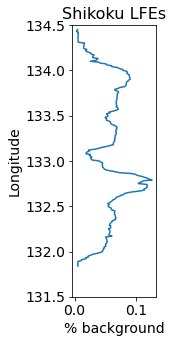

In [188]:
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(fraction)*100,t)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('% background',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


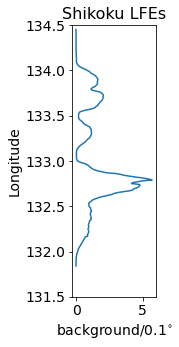

In [189]:
plt.figure(figsize=(1.5,5))
plt.plot(np.asarray(fraction)*counts,t)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel(r'background/0.1$^{\circ}$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(131.5,134.5)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

## Schuster Test

In [167]:
# Follow Matlab version by Thomas Ader

def Schuster_test(data,periods):
  log_prob = []
  data = np.asarray(data) - min(data)
  for i in range(len(periods)):
    T = periods[i]

    # Only use round number of cycles to prevent artifacts
    tlim = max(data)-(max(data)%T)
    t = np.asarray(data[data<=tlim])

    # Calculate the phase
    phase = (t%T)*2*np.pi/T

    # Schuster walk calculation
    end_walk_x = sum(np.cos(phase))
    end_walk_y = sum(np.sin(phase))

    # Calculate distance from origin
    D = np.sqrt(end_walk_x**2+end_walk_y**2)

    # Calculate probability
    log_prob.append(-D*D/len(t))

  return log_prob

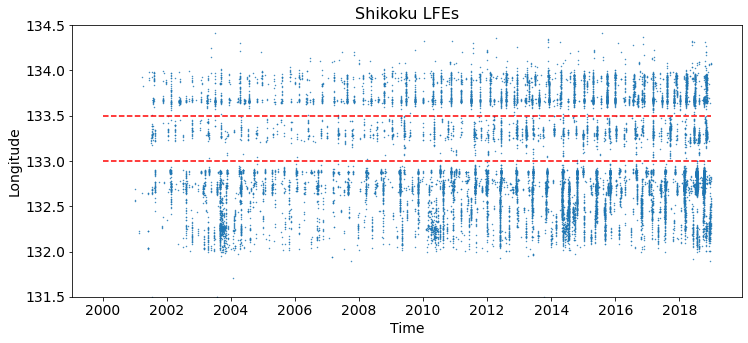

In [168]:
# Longitude-time plot
plt.figure(figsize=(12,5))
plt.scatter(shikoku_time,shikoku_lon,s=0.2)
plt.plot([datetime(2000,1,1),datetime(2018,12,31)],[133.0,133.0],'r--')
plt.plot([datetime(2000,1,1),datetime(2018,12,31)],[133.5,133.5],'r--')
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(datetime(2015, 5, 1),datetime(2015, 7, 1))
plt.ylim(131.5,134.5)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

### Longitude < 133

In [174]:
mask = (shikoku_lon<=133)
cluster_time = shikoku_time[mask]

## Convert to year
convert_dt = np.vectorize(lambda x: x.total_seconds())
cluster_time = convert_dt(cluster_time-datetime(2000,1,1))/(365*24*60*60)
cluster_time = cluster_time - min(cluster_time)

## Generate array of periods to be tested (based on Thomas Ader code in Matlab)
eps = 1;
T_max = 5 
T_min = 1e-3
t_span = max(cluster_time)
T_test = 1/np.arange(1/T_max,1/T_min,eps/t_span)

## Calculate Schuster spectrum
log_prob = Schuster_test(cluster_time,T_test)

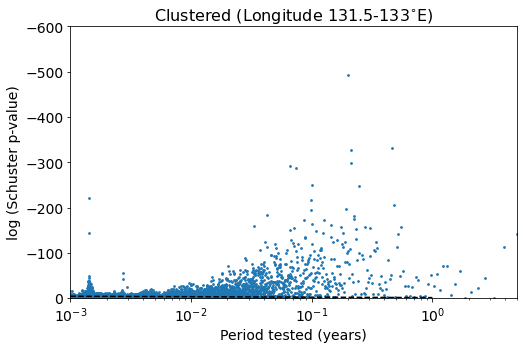

In [175]:
plt.figure(figsize=(8,5))
plt.scatter(T_test,np.log10(np.exp(1))*np.asarray(log_prob),s=3)
plt.plot([1e-3,1],np.log10(np.asarray([1e-3/19,1/19])),'k--')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Period tested (years)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log (Schuster p-value)',fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1e-3,5)
plt.ylim(0,-600)
plt.title(r'Clustered (Longitude 131.5-133$^{\circ}$E)',fontsize=16)
plt.show()

In [176]:
T_test[log_prob==min(log_prob)]

array([ 0.19860294])

### Longitude 133-133.5

In [177]:
mask = (shikoku_lon>=133) & (shikoku_lon<133.5)
cluster_time = shikoku_time[mask]

## Convert to year
convert_dt = np.vectorize(lambda x: x.total_seconds())
cluster_time = convert_dt(cluster_time-datetime(2000,1,1))/(365*24*60*60)
cluster_time = cluster_time - min(cluster_time)

## Generate array of periods to be tested (based on Thomas Ader code in Matlab)
eps = 1;
T_max = 5 
T_min = 1e-3
t_span = max(cluster_time)
T_test = 1/np.arange(1/T_max,1/T_min,eps/t_span)

## Calculate Schuster spectrum
log_prob = Schuster_test(cluster_time,T_test)

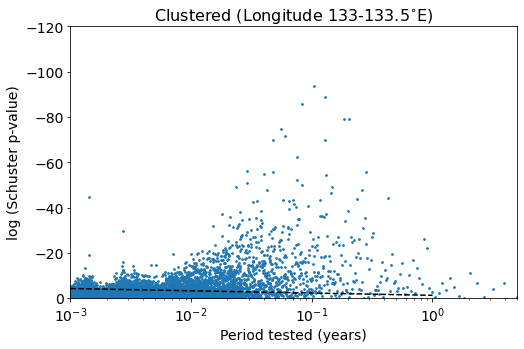

In [178]:
plt.figure(figsize=(8,5))
plt.scatter(T_test,np.log10(np.exp(1))*np.asarray(log_prob),s=3)
plt.plot([1e-3,1],np.log10(np.asarray([1e-3/19,1/19])),'k--')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Period tested (years)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log (Schuster p-value)',fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1e-3,5)
plt.ylim(0,-120)
plt.title(r'Clustered (Longitude 133-133.5$^{\circ}$E)',fontsize=16)
plt.show()

In [179]:
T_test[log_prob==min(log_prob)]

array([ 0.1035675])

### Longitude > 133.5

In [180]:
mask = (shikoku_lon>=133.5)
cluster_time = shikoku_time[mask]

## Convert to year
convert_dt = np.vectorize(lambda x: x.total_seconds())
cluster_time = convert_dt(cluster_time-datetime(2000,1,1))/(365*24*60*60)
cluster_time = cluster_time - min(cluster_time)

## Generate array of periods to be tested (based on Thomas Ader code in Matlab)
eps = 1;
T_max = 5 
T_min = 1e-3
t_span = max(cluster_time)
T_test = 1/np.arange(1/T_max,1/T_min,eps/t_span)

## Calculate Schuster spectrum
log_prob = Schuster_test(cluster_time,T_test)

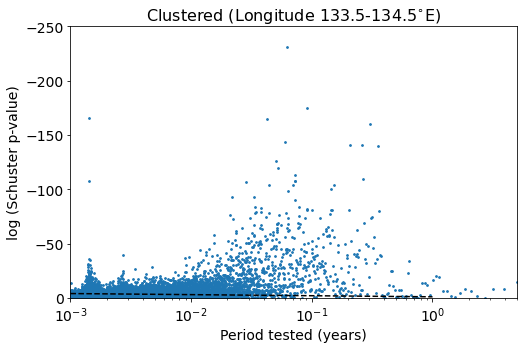

In [181]:
plt.figure(figsize=(8,5))
plt.scatter(T_test,np.log10(np.exp(1))*np.asarray(log_prob),s=3)
plt.plot([1e-3,1],np.log10(np.asarray([1e-3/19,1/19])),'k--')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Period tested (years)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log (Schuster p-value)',fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1e-3,5)
plt.ylim(0,-250)
plt.title(r'Clustered (Longitude 133.5-134.5$^{\circ}$E)',fontsize=16)
plt.show()

In [182]:
T_test[log_prob==min(log_prob)]

array([ 0.06240054])

### Declustered catalog

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


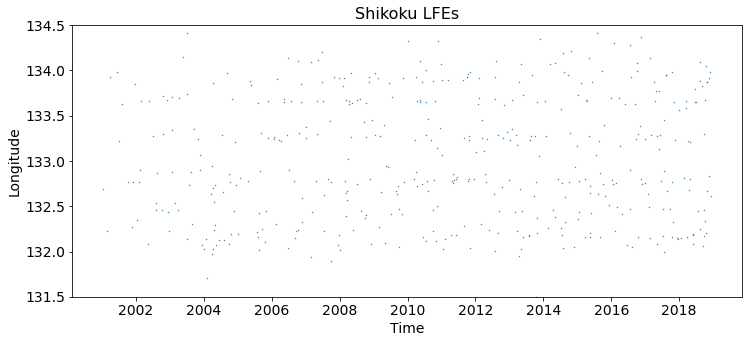

In [158]:
index = (np.log10(R)>-np.log10(T)-3.2)
decluster_time = shikoku_time[index]

# Longitude-time plot
plt.figure(figsize=(12,5))
plt.scatter(decluster_time,decluster_lon,s=0.2)
plt.xlabel('Time',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(datetime(2015, 5, 1),datetime(2015, 7, 1))
plt.ylim(131.5,134.5)
plt.title('Shikoku LFEs',fontsize=16)
plt.show()

In [159]:
## Convert to year
convert_dt = np.vectorize(lambda x: x.total_seconds())
decluster_time = convert_dt(decluster_time-datetime(2000,1,1))/(365*24*60*60)
decluster_time = decluster_time - min(decluster_time)

## Generate array of periods to be tested (based on Thomas Ader code in Matlab)
eps = 1;
T_max = 5 
T_min = 1e-3
t_span = max(decluster_time)
T_test = 1/np.arange(1/T_max,1/T_min,eps/t_span)

## Calculate Schuster spectrum
log_prob = Schuster_test(decluster_time,T_test)

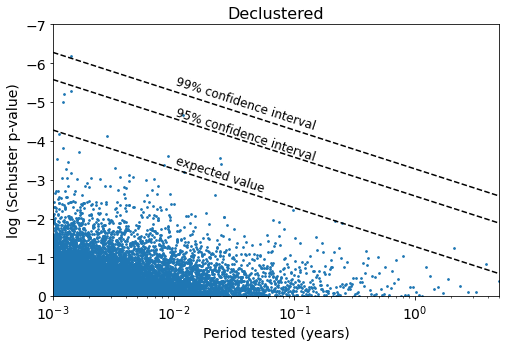

In [166]:
plt.figure(figsize=(8,5))
plt.scatter(T_test,np.log10(np.exp(1))*np.asarray(log_prob),s=3)
plt.plot([1e-3,5],np.log10(np.asarray([1e-3/19,5/19])),'k--')
plt.plot([1e-3,5],np.log10(0.05*np.asarray([1e-3/19,5/19])),'k--')
plt.plot([1e-3,5],np.log10(0.01*np.asarray([1e-3/19,5/19])),'k--')
plt.text(1e-2,-2.7,'expected value',fontsize=12,rotation=-18)
plt.text(1e-2,-3.5,'95% confidence interval',fontsize=12,rotation=-18)
plt.text(1e-2,-4.3,'99% confidence interval',fontsize=12,rotation=-18)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Period tested (years)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('log (Schuster p-value)',fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1e-3,5)
plt.ylim(0,-7)
plt.title('Declustered',fontsize=16)
plt.show()